In [2]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import math
import pandas as pd
import random
from scipy import stats
import torch
import seaborn as sns
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
import matplotlib.cm as cm  

In [2]:
def load_VAE():
    autoencoder = VAE(
        num_genes=18996,#16652,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    # autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_v1/model_seed=0_step=499999.pt'))
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint_nodrop/muris_scimilarity_lognorm_finetune_nodrop/model_seed=0_step=150000.pt'))
    return autoencoder

载入原始数据

In [44]:
adata = sc.read_h5ad('../data/tabula_muris/all.h5ad')
# adata = sc.read_h5ad('../data/tabula_muris/all_scGAN.h5ad')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=10)
gene_names = adata.var_names

# HVG时用这些
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # scGAN
# sc.pp.normalize_total(adata, target_sum=2e4)
# sc.pp.filter_genes_dispersion(adata, n_top_genes=1501)
# sc.pp.normalize_total(adata, target_sum=2500)

cell_data = adata.X.toarray()[1::30]

# VAE用这个
# autoencoder = load_VAE()
# cell_data = autoencoder(torch.tensor(cell_data),return_latent=True)
# cell_data = cell_data.cpu().detach().numpy()

cell_data.shape

(1901, 18996)

载入scGAN生成数据

In [37]:
adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/scGAN_gen_muris.h5ad')
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
adata.var_names = np.load('/data1/lep/Workspace/guided-diffusion/data/gene_name/gene_name_muris_cscGAN.npy',allow_pickle=True)
adata = adata[:,gene_names]

cell_gen = adata.X.toarray()[:10000]
cell_gen.shape

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


(10000, 18996)

载入diffusion生成

In [32]:
npzfile=np.load('../output/muris_scimilarity.npz',allow_pickle=True)

cell_gen_all = npzfile['cell_gen'][:5700]

# VAE用
autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()#[:11400]

# ori = ad.AnnData(cell_gen_all, dtype=np.float32)

# real = adata[adata.obs['celltype']=='neuroendocrine cell']
# dis = np.array([np.linalg.norm(real.X.mean(axis=0)-it) for it in ori.X])
# # find all the index where dis is smaller than 100
# idx = np.where(dis<300)[0]
# ori = ori[idx]
# ori.obs['celltype'] = pd.Categorical(np.array(['CD4+/CD45RO+ Memory']*ori.X.shape[0]))
# print(ori)

# cell_gen = cell_gen_all * (cell_gen_all>0)
# cell_gen = np.exp(cell_gen)-1
# adata_gen = ad.AnnData(cell_gen)
# sc.pp.normalize_total(adata_gen, 1e4)
# cell_gen = adata_gen.X

cell_gen = cell_gen_all

cell_gen.shape

(5700, 18996)

载入scDesign生成数据

In [18]:
adata_scd = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/output/scdesign_muris_new.h5ad')
sc.pp.normalize_total(adata_scd,1e4)
sc.pp.log1p(adata_scd)

# index = np.random.choice(adata_scd.X.shape[0], size=5700, replace=False)
cell_gen = adata_scd.X#[index]
cell_gen.shape

(1901, 18996)

存成csv给simbench用

In [5]:
cell_names = ['cell_'+str(i) for i in range(cell_gen.shape[0])]
gene_names = ['gene_'+str(i) for i in range(cell_gen.shape[1])]

df = pd.DataFrame(cell_gen.T,index=gene_names,columns=cell_names)
df.to_csv('tmp_data/sim.csv')
df = pd.DataFrame(cell_data.T,index=gene_names,columns=cell_names)
df.to_csv('tmp_data/real.csv')

相关系数

In [19]:
print(cell_data.mean())
print(cell_gen.mean())
print('spearman=',stats.spearmanr(cell_data.mean(axis=0), cell_gen.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(cell_data.mean(axis=0), cell_gen.mean(axis=0))[0][1])
# np.std(cell_data.mean(axis=0))
np.linalg.norm(cell_gen.mean(axis=0)-cell_data.mean(axis=0))

0.12532392
0.12719967148726655
spearman= 0.989853947141202
pearson= 0.9990914331858488


1.8849827487718853

Wasserstein距离

In [20]:
from scipy.stats import wasserstein_distance
distance = wasserstein_distance(cell_data.mean(axis=0), cell_gen.mean(axis=0))
print(distance)

0.0019802884143004995


MMD

In [21]:
import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵, 即上文中的K
    Params: 
	    source: 源域数据(n * len(x))
	    target: 目标域数据(m * len(y))
	    kernel_mul: 
	    kernel_num: 取不同高斯核的数量
	    fix_sigma: 不同高斯核的sigma值
	Return:
		sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()[0])# 求矩阵的行数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)#将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #求任意两个数据之间的和，得到的矩阵中坐标（i,j）代表total中第i行数据和第j行数据之间的l2 distance(i==j时为0）
    L2_distance = ((total0-total1)**2).sum(2) 
    #调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    #以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    #高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    #得到最终的核矩阵
    return sum(kernel_val)#/len(kernel_val)

def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
	    source: 源域数据(n * len(x))
	    target: 目标域数据(m * len(y))
	    kernel_mul: 
	    kernel_num: 取不同高斯核的数量
	    fix_sigma: 不同高斯核的sigma值
	Return:
		loss: MMD loss
    '''
    batch_size = int(source.size()[0])#一般默认为源域和目标域的batchsize相同
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    #根据式（3）将核矩阵分成4部分
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss#因为一般都是n==m，所以L矩阵一般不加入计算

In [22]:
# 再转回anndata便于scanpy处理
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

In [23]:
from torch.autograd import Variable
sc.tl.pca(adata, svd_solver='arpack')# svd_solver 指定奇异值分解 SVD 的方法
real = adata[adata.obs_names=='true_Cell'].obsm['X_pca'][:1900]
gen = adata[adata.obs_names=='gen_Cell'].obsm['X_pca'][:1900]
X = torch.Tensor(real)
Y = torch.Tensor(gen)
X,Y = Variable(X), Variable(Y)
print(mmd_rbf(X,Y))

tensor(0.0743)


scib

In [24]:
import scib
# cell_data = ori_adata.X[:1000]
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])])

# sc.pp.highly_variable_genes(adata)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]
# sc.pp.scale(adata)
# print(adata)

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

# sc.tl.umap(adata)
# adata.obsm['X_emb']=adata.obsm['X_umap']

scib.me.ilisi_graph(adata, batch_key="batch", type_="knn")

0.17457585757188787

条件生成

random forest

In [38]:
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
def random_forest(adata):
    real = adata[adata.obs_names=='true_Cell'].X.toarray()#.obsm['X_pca']
    sim = adata[adata.obs_names=='gen_Cell'].X.toarray()#.obsm['X_pca']#

    data = np.concatenate((real,sim),axis=0)
    label = np.concatenate((np.ones((real.shape[0])),np.zeros((sim.shape[0]))))

    ##将训练集切分为训练集和验证集
    X_train,X_val,y_train,y_val = train_test_split(data, label,
                                                test_size = 0.25,random_state = 1)

    ## 使用随机森林对数据进行分类
    rfc = RandomForestClassifier(n_estimators = 1000, # 树的数量
                                max_depth= 5,       # 子树最大深度
                                oob_score=True,
                                class_weight = "balanced",
                                random_state=1)
    rfc.fit(X_train,y_train)

    feature_importances = rfc.feature_importances_  
    # # 打印每个特征的重要性  
    # for feature, importance in zip(list(range(50)), feature_importances):  
    #     print(f"Feature: {feature}, Importance: {importance}")

    pre_y = rfc.predict_proba(X_val)[:, 1]
    fpr_Nb, tpr_Nb, _ = roc_curve(y_val, pre_y)
    aucval = auc(fpr_Nb, tpr_Nb)    # 计算auc的取值
    print(aucval)
    return aucval,feature_importances

In [39]:
# diffusion

# cato = ['blood cell', 'endothelial cell', 'epithelial cell', 'mesenchymal cell', 'neuroendocrine cell']
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
# index = ['0','1','2','3','4']
rf = []

cell_gen_all = []
gen_class = []
length_per_type = 3000

for i in range(12):#index2:
    npzfile=np.load(f'../output/muris_condi/muris_{i}_scimilarity_nodrop.npz',allow_pickle=True)
    cell_gen_all.append(npzfile['cell_gen'][:length_per_type])#.squeeze(1)
    gen_class+=['gen '+cato[i]]*length_per_type
cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

for i in range(12):
    cell_diff = cell_gen_all[i*length_per_type:(i+1)*length_per_type]
    ori = ad.AnnData(cell_diff, dtype=np.float32)
    ori.var_names = gene_names

    length = min(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0],length_per_type)
    # length = int(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0]/2)
    # ori = adata[adata.obs['celltype'] == cato[i]][-length:]

    adata1 = ad.concat((adata[adata.obs['celltype'] == cato[i]][:length],ori[:length]))
    adata1.obs_names = [f"true_Cell" for i in range(length)]+[f"gen_Cell" for i in range(ori[:length].X.shape[0])]

    # sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
    # adata1.raw = adata1
    # adata1 = adata1[:, adata1.var.highly_variable]
    # sc.pp.scale(adata1)
    # sc.pp.log1p(adata1)
    
    sc.tl.pca(adata1, svd_solver='arpack')
    score, feature_importances = random_forest(adata1)
    rf.append(score)
# print(np.mean(rf))

1.0
1.0


KeyboardInterrupt: 

In [10]:
# cscGAN

# cato = ['blood cell', 'endothelial cell', 'epithelial cell', 'mesenchymal cell', 'neuroendocrine cell']
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
# index = ['0','1','2','3','4']
rf = []
length_per_type=3000

adata_gan = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/cscGAN_gen_muris.h5ad')
sc.pp.normalize_total(adata_gan, target_sum=1e4)
# sc.pp.log1p(adata_gan)
adata_gan.var_names = np.load('/data1/lep/Workspace/guided-diffusion/data/gene_name/gene_name_muris_cscGAN.npy',allow_pickle=True)
adata_gan = adata_gan[:,gene_names]

for i in range(12):#index2:
    cell_gan = adata_gan[adata_gan.obs['cluster']==str(i)][:length_per_type].X.toarray()
    ori = ad.AnnData(cell_gan, dtype=np.float32)
    ori.var_names = gene_names

    length = min(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0],length_per_type)
    # length = int(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0]/2)
    # ori = adata[adata.obs['celltype'] == cato[i]][-length:]

    adata1 = ad.concat((adata[adata.obs['celltype'] == cato[i]][:length],ori[:length]))
    adata1.obs_names = [f"true_Cell" for i in range(length)]+[f"gen_Cell" for i in range(ori[:length].shape[0])]

    sc.tl.pca(adata1, svd_solver='arpack')
    score = random_forest(adata1)
    rf.append(score)
print(np.mean(rf))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


knn

In [41]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

def knn_classify(adata):
    real = adata[adata.obs_names=='true_Cell'].X.toarray()#.obsm['X_pca']
    sim = adata[adata.obs_names=='gen_Cell'].X.toarray()#.obsm['X_pca']#

    data = np.concatenate((real,sim),axis=0)
    label = np.concatenate((np.ones((real.shape[0])),np.zeros((sim.shape[0]))))

    knn_classifier = KNeighborsClassifier(n_neighbors=5)  
    
    ##将训练集切分为训练集和验证集
    X_train,X_val,y_train,y_val = train_test_split(data, label,
                                                test_size = 0.3,random_state = 1)
    knn_classifier.fit(X_train, y_train)
    predicted_label = knn_classifier.predict(X_val)
    # print((predicted_label==y_val).sum()/X_val.shape[0])
    accuracy = accuracy_score(predicted_label, y_val)

    # 算AUC
    predicted_probabilities = knn_classifier.predict_proba(X_val)[:, 1]  
    
    # 计算AUC，只适用于二分类问题  
    # AUC需要真实标签和正类的预测概率  
    auc = roc_auc_score(y_val, predicted_probabilities)  
    print(f"AUC: {auc}, Accuracy: {accuracy}") 

    return accuracy, auc

In [42]:
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
knn_acc = []
knn_auc = []
cell_gen_all = []
gen_class = []
index2 = list(range(12))
length_per_type = 1000

for i in range(12):
    npzfile=np.load(f'../output/muris_condi/muris_{i}_scimilarity_nodrop.npz',allow_pickle=True)
    cell_gen_all.append(npzfile['cell_gen'][:length_per_type])
    gen_class+=['gen '+cato[i]]*length_per_type
cell_gen_all = np.concatenate(cell_gen_all,axis=0)
# print(cell_gen_all.shape)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

for i in range(12):
    cell_diff = cell_gen_all[i*length_per_type:(i+1)*length_per_type]
    ori = ad.AnnData(cell_diff, dtype=np.float32)
    ori.var_names = gene_names

    length = min(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0],length_per_type)
    # length = int(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0]/2)
    # ori = adata[adata.obs['celltype'] == cato[i]][-length:]

    adata1 = ad.concat((adata[adata.obs['celltype'] == cato[i]][:length],ori[:length]))
    adata1.obs_names = [f"true_Cell" for i in range(length)]+[f"gen_Cell" for i in range(ori[:length].X.shape[0])]

    sc.tl.pca(adata1, svd_solver='arpack')
    acc, auc = knn_classify(adata1)
    knn_acc.append(acc)
    knn_auc.append(auc)
print(np.mean(knn_acc))
print(knn_acc)
print(knn_auc)

AUC: 0.5050333892598806, Accuracy: 0.5016666666666667
AUC: 0.5, Accuracy: 0.48091603053435117
AUC: 0.5083612040133779, Accuracy: 0.5016666666666667
AUC: 0.5066889632107023, Accuracy: 0.5016666666666667
AUC: 0.5083612040133779, Accuracy: 0.5016666666666667
AUC: 0.5066889632107023, Accuracy: 0.5066666666666667
AUC: 0.5033444816053512, Accuracy: 0.5016666666666667
AUC: 0.5083612040133779, Accuracy: 0.5016666666666667
AUC: 0.500016666851854, Accuracy: 0.5016666666666667
AUC: 0.5016722408026756, Accuracy: 0.5016666666666667
AUC: 0.5050167224080268, Accuracy: 0.505


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AUC: 0.5016722408026756, Accuracy: 0.5016666666666667
0.5006318914334182
[0.5016666666666667, 0.48091603053435117, 0.5016666666666667, 0.5016666666666667, 0.5016666666666667, 0.5066666666666667, 0.5016666666666667, 0.5016666666666667, 0.5016666666666667, 0.5016666666666667, 0.505, 0.5016666666666667]
[0.5050333892598806, 0.5, 0.5083612040133779, 0.5066889632107023, 0.5083612040133779, 0.5066889632107023, 0.5033444816053512, 0.5083612040133779, 0.500016666851854, 0.5016722408026756, 0.5050167224080268, 0.5016722408026756]


In [45]:
# cscGAN
adata_gan = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/cscGAN_gen_muris.h5ad')
adata_gan.var_names = np.load('/data1/lep/Workspace/guided-diffusion/data/gene_name/gene_name_muris_cscGAN.npy',allow_pickle=True)
adata_gan = adata_gan[:,gene_names]
length_per_type=1000
knn_acc=[]
knn_auc=[]

for i in range(12):
    cell_diff = adata_gan[adata_gan.obs['cluster']==str(i)][:length_per_type].X.toarray()
    ori = ad.AnnData(cell_diff, dtype=np.float32)
    ori.var_names = gene_names
    sc.pp.normalize_total(ori, 1e4)
    # sc.pp.log1p(ori)

    length = min(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0],length_per_type)
    # length = int(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0]/2)
    # ori = adata[adata.obs['celltype'] == cato[i]][-length:]

    adata1 = ad.concat((adata[adata.obs['celltype'] == cato[i]][:length],ori[:length]))
    adata1.obs_names = [f"true_Cell" for i in range(length)]+[f"gen_Cell" for i in range(ori[:length].X.shape[0])]

    sc.tl.pca(adata1, svd_solver='arpack')
    acc, auc = knn_classify(adata1)
    knn_acc.append(acc)
    knn_auc.append(auc)
print(np.mean(knn_acc))
print(knn_acc)
print(knn_auc)

AUC: 1.0, Accuracy: 1.0
AUC: 1.0, Accuracy: 1.0


AUC: 1.0, Accuracy: 1.0
AUC: 1.0, Accuracy: 1.0
AUC: 0.9983277591973244, Accuracy: 0.995


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AUC: 0.9966666296292181, Accuracy: 0.9966666666666667


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AUC: 1.0, Accuracy: 1.0


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AUC: 0.9933554817275748, Accuracy: 0.985


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AUC: 0.9950166112956811, Accuracy: 0.99
AUC: 1.0, Accuracy: 1.0


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AUC: 1.0, Accuracy: 0.9966666666666667


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AUC: 0.9716330181446461, Accuracy: 0.965
0.9940277777777777
[1.0, 1.0, 1.0, 1.0, 0.995, 0.9966666666666667, 1.0, 0.985, 0.99, 1.0, 0.9966666666666667, 0.965]
[1.0, 1.0, 1.0, 1.0, 0.9983277591973244, 0.9966666296292181, 1.0, 0.9933554817275748, 0.9950166112956811, 1.0, 1.0, 0.9716330181446461]


In [43]:
# scdesign

adata_scd = sc.read_h5ad('../output/scdesign_muris_new.h5ad')
length_per_type=1000
knn_acc=[]
knn_auc=[]

for i in range(12):
    cell_diff = adata_scd[adata_scd.obs['cell_type']==cato[i]][:length_per_type].X.toarray()
    ori = ad.AnnData(cell_diff, dtype=np.float32)
    ori.var_names = gene_names
    sc.pp.normalize_total(ori, 1e4)
    sc.pp.log1p(ori)

    length = min(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0],cell_diff.shape[0])
    # length = int(adata[adata.obs['celltype'] == cato[i]].X.toarray().shape[0]/2)
    # ori = adata[adata.obs['celltype'] == cato[i]][-length:]

    adata1 = ad.concat((adata[adata.obs['celltype'] == cato[i]][:length],ori[:length]))
    adata1.obs_names = [f"true_Cell" for i in range(length)]+[f"gen_Cell" for i in range(ori[:length].X.shape[0])]

    sc.tl.pca(adata1, svd_solver='arpack')
    acc, auc = knn_classify(adata1)
    knn_acc.append(acc)
    knn_auc.append(auc)
print(np.mean(knn_acc))
print(knn_acc)
print(knn_auc)

AUC: 0.8315384615384614, Accuracy: 0.6078431372549019
AUC: 0.8222222222222222, Accuracy: 0.7142857142857143
AUC: 0.9864532019704434, Accuracy: 0.6842105263157895
AUC: 0.8024661508704062, Accuracy: 0.5274725274725275
AUC: 0.7241847826086957, Accuracy: 0.41025641025641024
AUC: 0.8202457264957266, Accuracy: 0.41935483870967744
AUC: 0.9300889328063241, Accuracy: 0.8111111111111111
AUC: 0.9020979020979021, Accuracy: 0.8192771084337349


AUC: 0.876568124795462, Accuracy: 0.7708333333333334
AUC: 0.630952380952381, Accuracy: 0.6551724137931034
AUC: 0.7880935506732814, Accuracy: 0.46357615894039733


/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AUC: 0.7047145430339102, Accuracy: 0.6814159292035398
0.6304007674258534
[0.6078431372549019, 0.7142857142857143, 0.6842105263157895, 0.5274725274725275, 0.41025641025641024, 0.41935483870967744, 0.8111111111111111, 0.8192771084337349, 0.7708333333333334, 0.6551724137931034, 0.46357615894039733, 0.6814159292035398]
[0.8315384615384614, 0.8222222222222222, 0.9864532019704434, 0.8024661508704062, 0.7241847826086957, 0.8202457264957266, 0.9300889328063241, 0.9020979020979021, 0.876568124795462, 0.630952380952381, 0.7880935506732814, 0.7047145430339102]


分类器指标celltypist

diffusion条件生成

In [9]:
import celltypist
# cato = ['blood cell', 'endothelial cell', 'epithelial cell', 'mesenchymal cell', 'neuroendocrine cell']
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
index = [0,1,2,3,4,5,6,7,8,9,10,11]
rf = []
diffu_acc = []

cell_gen_all = []
gen_class = []

for i in range(12):#index2:
    npzfile=np.load(f'../output/muris_condi/muris_{i}_scimilarity_nodrop.npz',allow_pickle=True)
    length = 1000
    cell_gen_all.append(npzfile['cell_gen'][:int(length)])#.squeeze(1)

    gen_class+=['gen '+cato[i]]*int(length)

cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

accs = []
for i in index:
    cell = cell_gen_all[i*1000:(i+1)*1000]
    # cell = (cell>0)*cell
    # cell_gen = np.exp(cell)-1
    ori = ad.AnnData(cell, dtype=np.float32)
    ori.var_names = gene_names
    # sc.pp.normalize_total(ori,1e4)
    # sc.pp.log1p(ori)
    ori.X = (ori.X>np.log1p(10000)) * (np.log1p(10000)-1e-6) + ori.X * (ori.X<np.log1p(10000))
    
    predictions = celltypist.annotate(ori, model = '../checkpoint_old/celltypist_muris_all_re2.pkl')
    acc = (predictions.predicted_labels.squeeze(1).values == cato[i]).sum()/cell.shape[0]
    # print(cato[i],acc)
    accs.append((cato[i],acc))
    diffu_acc.append(acc)
print(accs)

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ 

[('Bladder', 0.987), ('Heart_and_Aorta', 0.665), ('Kidney', 0.915), ('Limb_Muscle', 0.917), ('Liver', 0.992), ('Lung', 0.941), ('Mammary_Gland', 0.899), ('Marrow', 0.953), ('Spleen', 0.996), ('Thymus', 0.925), ('Tongue', 0.996), ('Trachea', 0.983)]


In [ ]:
('Bladder', 0.987), ('Heart_and_Aorta', 0.665), ('Kidney', 0.915), ('Limb_Muscle', 0.917), ('Liver', 0.992), ('Lung', 0.941), 
('Mammary_Gland', 0.899), ('Marrow', 0.953), ('Spleen', 0.996), ('Thymus', 0.925), ('Tongue', 0.996), ('Trachea', 0.983)

In [ ]:
('Bladder', 0.886), ('Heart_and_Aorta', 0.586), ('Kidney', 0.972), ('Limb_Muscle', 0.903), ('Liver', 0.896), ('Lung', 0.948), 
('Mammary_Gland', 0.959), ('Marrow', 0.97), ('Spleen', 0.997), ('Thymus', 0.898), ('Tongue', 1.0), ('Trachea', 0.994)

In [33]:
('Bladder', 0.861), ('Heart_and_Aorta', 0.415), ('Kidney', 0.794), ('Limb_Muscle', 0.835), ('Liver', 0.974), ('Lung', 0.923), 
('Mammary_Gland', 0.783), ('Marrow', 0.907), ('Spleen', 0.953), ('Thymus', 0.871), ('Tongue', 0.948), ('Trachea', 0.979)

(12000, 18996)

cscGAN条件生成

In [10]:
import celltypist
# cato = ['blood cell', 'endothelial cell', 'epithelial cell', 'mesenchymal cell', 'neuroendocrine cell']
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
index = [0,1,2,3,4,5,6,7,8,9,10,11]
rf = []
gan_acc = []

adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/cscGAN_gen_muris.h5ad')
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
adata.var_names = np.load('/data1/lep/Workspace/guided-diffusion/data/gene_name/gene_name_muris_cscGAN.npy',allow_pickle=True)
adata = adata[:,gene_names]

accs = []
for i in index:
    cell = adata[adata.obs['cluster']==str(i)][:1000].X.toarray()
    # cell = (cell>0)*cell
    # cell_gen = np.exp(cell)-1
    ori = ad.AnnData(cell, dtype=np.float32)
    ori.var_names = gene_names
    sc.pp.normalize_total(ori,1e4)
    sc.pp.log1p(ori)
    ori.X = (ori.X>np.log1p(10000)) * (np.log1p(10000)-1e-6) + ori.X * (ori.X<np.log1p(10000))

    predictions = celltypist.annotate(ori, model = '../checkpoint_old/celltypist_muris_all_re2.pkl')
    acc = (predictions.predicted_labels.squeeze(1).values == cato[i]).sum()/cell.shape[0]
    # print(cato[i],acc)
    accs.append((cato[i],acc))
    gan_acc.append(acc)
print(accs)

🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 1000 cells and 18996 genes
🔗 Matching reference genes in the model
🧬

[('Bladder', 0.0), ('Heart_and_Aorta', 0.0), ('Kidney', 0.0), ('Limb_Muscle', 0.0), ('Liver', 0.0), ('Lung', 0.069), ('Mammary_Gland', 0.247), ('Marrow', 0.016), ('Spleen', 0.066), ('Thymus', 0.09), ('Tongue', 0.0), ('Trachea', 0.001)]


In [ ]:
('Bladder', 0.0), ('Heart_and_Aorta', 0.0), ('Kidney', 0.0), ('Limb_Muscle', 0.0), ('Liver', 0.0), ('Lung', 0.069), 
('Mammary_Gland', 0.247), ('Marrow', 0.016), ('Spleen', 0.066), ('Thymus', 0.09), ('Tongue', 0.0), ('Trachea', 0.001)

('Bladder', 0.0), ('Heart_and_Aorta', 0.0), ('Kidney', 0.0), ('Limb_Muscle', 0.0), ('Liver', 0.0), ('Lung', 0.069), 
('Mammary_Gland', 0.247), ('Marrow', 0.016), ('Spleen', 0.066), ('Thymus', 0.09), ('Tongue', 0.0), ('Trachea', 0.001)

scdesign

In [38]:
import celltypist
# cato = ['blood cell', 'endothelial cell', 'epithelial cell', 'mesenchymal cell', 'neuroendocrine cell']
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']
index = [0,1,2,3,4,5,6,7,8,9,10,11]
rf = []
gan_acc = []

adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/output/scdesign_muris.h5ad')
# gene_names = adata.var_names

accs = []
for i in index:
    cell = adata[adata.obs['cell_type']==cato[i]].X.toarray()
    # cell = (cell>0)*cell
    # cell_gen = np.exp(cell)-1
    ori = ad.AnnData(cell, dtype=np.float32)
    ori.var_names = gene_names
    sc.pp.normalize_total(ori,1e4)
    sc.pp.log1p(ori)
    ori.X = (ori.X>np.log1p(10000)) * (np.log1p(10000)-1e-6) + ori.X * (ori.X<np.log1p(10000))

    predictions = celltypist.annotate(ori, model = '../checkpoint_old/celltypist_muris_all_re2.pkl')
    acc = (predictions.predicted_labels.squeeze(1).values == cato[i]).sum()/cell.shape[0]
    # print(cato[i],acc)
    accs.append((cato[i],acc))
    gan_acc.append(acc)
print(accs)

🔬 Input data has 383 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 102 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 374 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 714 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 318 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 915 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996

[('Bladder', 1.0), ('Heart_and_Aorta', 1.0), ('Kidney', 1.0), ('Limb_Muscle', 1.0), ('Liver', 1.0), ('Lung', 1.0), ('Mammary_Gland', 1.0), ('Marrow', 0.9984076433121019), ('Spleen', 0.9974522292993631), ('Thymus', 1.0), ('Tongue', 1.0), ('Trachea', 1.0)]


celltypist测试集

In [11]:
accs = []
adata = sc.read_h5ad('../data/testset_muris_all2.h5ad')
# sc.pp.filter_genes(adata, min_cells=3)
# sc.pp.filter_cells(adata, min_genes=10)
# adata.var_names_make_unique()
# adata = adata[55000:]
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
real_acc = []
for i in range(len(cato)):
    predictions = celltypist.annotate(adata[adata.obs['celltype']==cato[i]], model = '../checkpoint_old/celltypist_muris_all_re2.pkl')
    acc = (predictions.predicted_labels.squeeze(1).values==cato[i]).sum()/adata[adata.obs['celltype']==cato[i]].X.shape[0]
    real_acc.append(acc)
    accs.append((cato[i],acc))
print(accs)

🔬 Input data has 498 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 129 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 541 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 908 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 389 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 1234 cells and 18996 genes
🔗 Matching reference genes in the model
🧬 1899

[('Bladder', 0.9879518072289156), ('Heart_and_Aorta', 0.9612403100775194), ('Kidney', 0.9852125693160814), ('Limb_Muscle', 0.9724669603524229), ('Liver', 0.9897172236503856), ('Lung', 0.9829821717990276), ('Mammary_Gland', 0.9666295884315906), ('Marrow', 0.9870588235294118), ('Spleen', 0.9916317991631799), ('Thymus', 0.9568345323741008), ('Tongue', 1.0), ('Trachea', 0.9982653946227233)]


draw plot

In [7]:
control_group = [0.9879518, 0.9612403, 0.9852125, 0.97246, 0.98971, 0.98298, 0.96662, 0.987058, 0.9916317, 0.95683, 1.0, 0.9982653]
diff_group = [0.987, 0.665, 0.915, 0.917, 0.992, 0.941, 0.899, 0.953, 0.996, 0.925, 0.996, 0.983]
scdesign_group = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998407, 0.997452, 1.0, 1.0, 1.0]
gan_group = [0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.247, 0.016, 0.066, 0.09, 0.0, 0.001]
print(np.mean(control_group),np.mean(diff_group),np.mean(scdesign_group),np.mean(gan_group))

0.9816633 0.9307500000000002 0.9996549166666666 0.04075


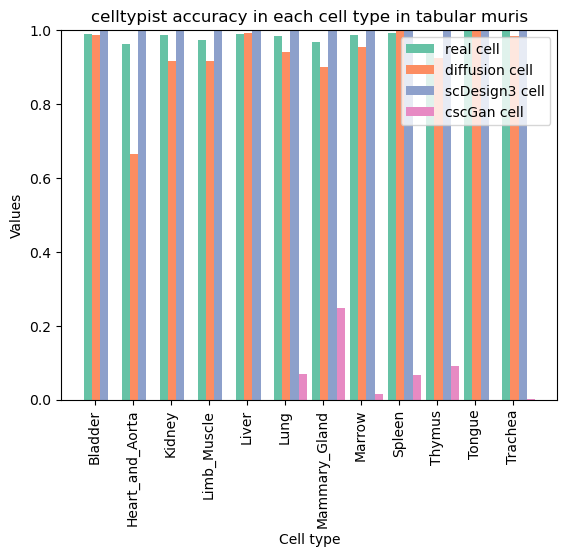

In [32]:
import matplotlib.cm as cm  

cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']

control_group = [0.9879518, 0.9612403, 0.9852125, 0.97246, 0.98971, 0.98298, 0.96662, 0.987058, 0.9916317, 0.95683, 1.0, 0.9982653]
diff_group = [0.987, 0.665, 0.915, 0.917, 0.992, 0.941, 0.899, 0.953, 0.996, 0.925, 0.996, 0.983]
scdesign_group = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998407, 0.997452, 1.0, 1.0, 1.0]
gan_group = [0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.247, 0.016, 0.066, 0.09, 0.0, 0.001]

bar_width = 0.3 
dx = 0.5

x1 = [i*1.4 for i in range(len(control_group))]  
x2 = [i + bar_width for i in x1]  
x3 = [i + bar_width*2 for i in x1]  
x4 = [i + bar_width*3 for i in x1]  

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

cmap = cm.get_cmap('Set2')
plt.bar(x1, control_group, width=bar_width, label="real cell", color=cmap(0))  
plt.bar(x2, diff_group, width=bar_width, label="diffusion cell", color=cmap(1))  
plt.bar(x3, scdesign_group, width=bar_width, label="scDesign3 cell", color=cmap(2))  
plt.bar(x4, gan_group, width=bar_width, label="cscGan cell", color=cmap(3))  


plt.xticks(np.array(range(12))*1.4+0.25, cato, rotation=90)  
plt.ylim((0,1))
  
plt.legend()  

plt.xlabel("Cell type")  
plt.ylabel("Values")  
plt.title("celltypist accuracy in each cell type in tabular muris")

# plt.show()  
plt.savefig('/data1/lep/Workspace/guided-diffusion/figure_pdf_new/celltypist_conditional_muris.pdf')

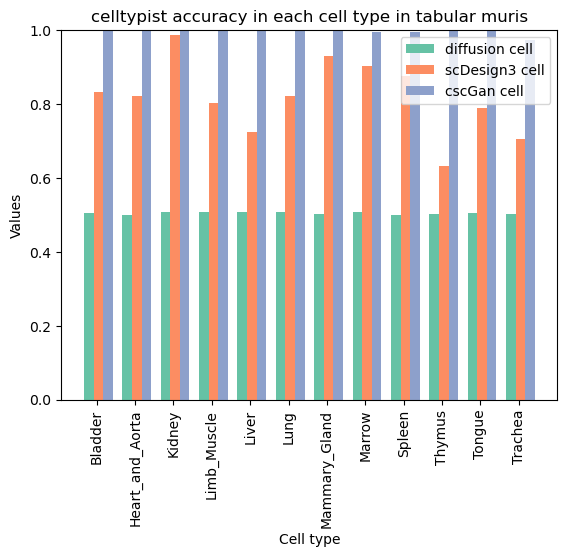

In [33]:
cato = ['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']

# control_group = [0.9879518, 0.9612403, 0.9852125, 0.97246, 0.98971, 0.98298, 0.96662, 0.987058, 0.9916317, 0.95683, 1.0, 0.9982653]
diff_group = [0.5050333892598806, 0.5, 0.5083612040133779, 0.5066889632107023, 0.5083612040133779, 0.5066889632107023, 0.5033444816053512, 0.5083612040133779, 0.500016666851854, 0.5016722408026756, 0.5050167224080268, 0.5016722408026756]
scdesign_group = [0.8315384615384614, 0.8222222222222222, 0.9864532019704434, 0.8024661508704062, 0.7241847826086957, 0.8202457264957266, 0.9300889328063241, 0.9020979020979021, 0.876568124795462, 0.630952380952381, 0.7880935506732814, 0.7047145430339102]
gan_group = [1.0, 1.0, 1.0, 1.0, 0.9983277591973244, 0.9966666296292181, 1.0, 0.9933554817275748, 0.9950166112956811, 1.0, 1.0, 0.9716330181446461]

bar_width = 0.3 
dx = 0.5

x1 = [i*1.2 for i in range(len(diff_group))]  
x2 = [i + bar_width for i in x1]  
x3 = [i + bar_width*2 for i in x1]  
# x4 = [i + bar_width*3 for i in x1]  

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

cmap = cm.get_cmap('Set2')
# plt.bar(x1, control_group, width=bar_width, label="real cell")  
plt.bar(x1, diff_group, width=bar_width, label="diffusion cell", color=cmap(0))  
plt.bar(x2, scdesign_group, width=bar_width, label="scDesign3 cell", color=cmap(1))  
plt.bar(x3, gan_group, width=bar_width, label="cscGan cell", color=cmap(2))  


plt.xticks(np.array(range(12))*1.2+0.25, cato, rotation=90)  
plt.ylim((0,1))
  
plt.legend()  

plt.xlabel("Cell type")  
plt.ylabel("Values")  
plt.title("celltypist accuracy in each cell type in tabular muris")

# plt.show()  
plt.savefig('/data1/lep/Workspace/guided-diffusion/figure_pdf_new/knn_conditional_muris.pdf')

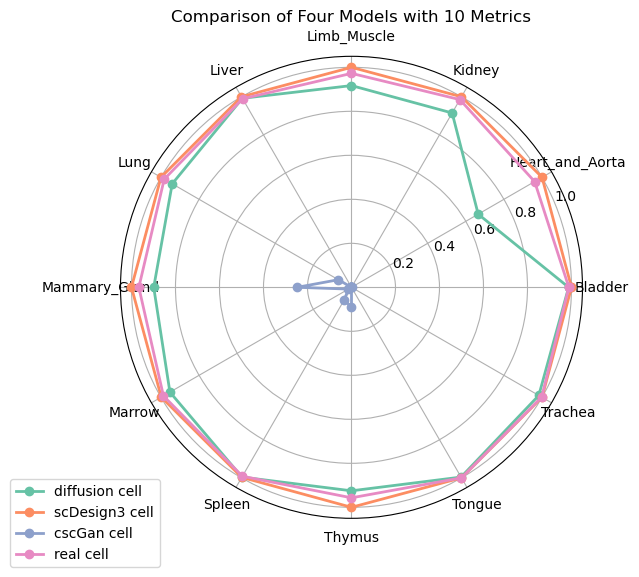

In [6]:
# celltypist

# 创建数据  
labels=np.array(['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea'])  

stats=np.array([  
[0.987, 0.665, 0.915, 0.917, 0.992, 0.941, 0.899, 0.953, 0.996, 0.925, 0.996, 0.983],                              # diffusion
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998407, 0.997452, 1.0, 1.0, 1.0],                                              # scdesign
[0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.247, 0.016, 0.066, 0.09, 0.0, 0.001],                                              # cscGan
[0.9879518, 0.9612403, 0.9852125, 0.97246, 0.98971, 0.98298, 0.96662, 0.987058, 0.9916317, 0.95683, 1.0, 0.9982653],  # control group
])  
  
# 角度  
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()  
angles+=angles[:1]  # 闭合图形  

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# 绘制雷达图  
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))  
cmap = cm.get_cmap('Set2')
for i, stat in enumerate(stats):  
    ax.plot(angles, np.concatenate((stat, [stat[0]])), '-o', linewidth=2, color=cmap(i))  # 闭合数据  
  
# 设置雷达图的标签  
ax.set_thetagrids(np.degrees(angles[:-1]), labels)  # 设置刻度标签，去除闭合点的重复标签  
  
# 添加标题和图例  
plt.title('Comparison of Four Models with 10 Metrics')  
ax.legend(['diffusion cell', 'scDesign3 cell', 'cscGan cell','real cell'], loc='upper right', bbox_to_anchor=(0.1, 0.1))  
  
# 显示图形  
# plt.show()  
plt.savefig('/data1/lep/Workspace/guided-diffusion/figure_pdf_new/celltypist_conditional_radar_muris.pdf')

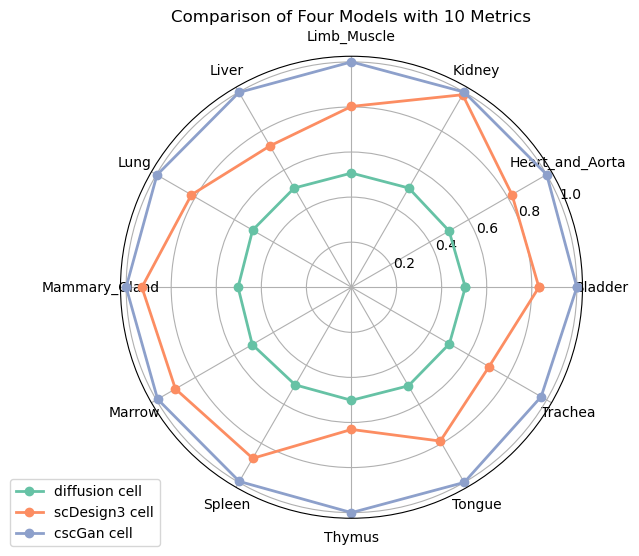

In [5]:
# knn

# 创建数据  
labels=np.array(['Bladder', 'Heart_and_Aorta', 'Kidney', 'Limb_Muscle', 'Liver',
       'Lung', 'Mammary_Gland', 'Marrow', 'Spleen', 'Thymus', 'Tongue',
       'Trachea']) 

stats=np.array([ 
[0.5050333892598806, 0.5, 0.5083612040133779, 0.5066889632107023, 0.5083612040133779, 0.5066889632107023, 0.5033444816053512, 0.5083612040133779, 0.500016666851854, 0.5016722408026756, 0.5050167224080268, 0.5016722408026756],                              # diffusion
[0.8315384615384614, 0.8222222222222222, 0.9864532019704434, 0.8024661508704062, 0.7241847826086957, 0.8202457264957266, 0.9300889328063241, 0.9020979020979021, 0.876568124795462, 0.630952380952381, 0.7880935506732814, 0.7047145430339102], # scdesign
[1.0, 1.0, 1.0, 1.0, 0.9983277591973244, 0.9966666296292181, 1.0, 0.9933554817275748, 0.9950166112956811, 1.0, 1.0, 0.9716330181446461],                                              # cscGan
])  
  
# 角度  
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()  
angles+=angles[:1]  # 闭合图形  

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# 绘制雷达图  
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))  
cmap = cm.get_cmap('Set2')
for i, stat in enumerate(stats):  
    ax.plot(angles, np.concatenate((stat, [stat[0]])), '-o', linewidth=2, color=cmap(i))  # 闭合数据  
  
# 设置雷达图的标签  
ax.set_thetagrids(np.degrees(angles[:-1]), labels)  # 设置刻度标签，去除闭合点的重复标签  
  
# 添加标题和图例  
plt.title('Comparison of Four Models with 10 Metrics')  
ax.legend(['diffusion cell', 'scDesign3 cell', 'cscGan cell'], loc='upper right', bbox_to_anchor=(0.1, 0.1))  
  
# 显示图形  
# plt.show()  
plt.savefig('/data1/lep/Workspace/guided-diffusion/figure_pdf_new/knn_conditional_radar_muris.pdf')

散点图

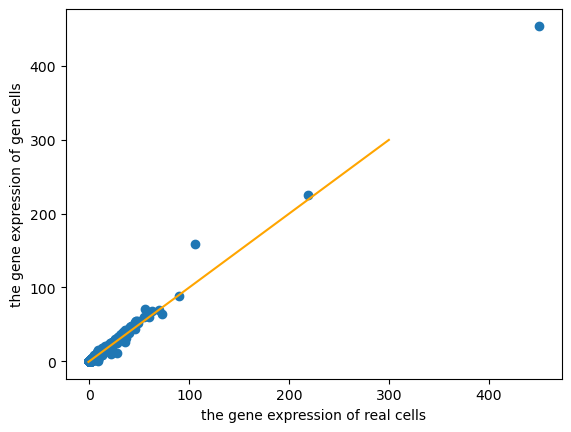

In [26]:
# generated=generated*(generated>0)
plt.figure()
# plt.ylim((-2,10))
# plt.xlim((-2,10))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(cell_data.mean(axis=0),cell_gen.mean(axis=0))
# plt.scatter(cell_data.mean(axis=0),npzfile['traj'][-2].mean(axis=0))
plt.plot([-1,300],[-1,300],color='orange')
# stats.spearmanr(cell_data2.mean(axis=0),cell_data1.mean(axis=0))

gene correlation matrix

In [73]:
# 再转回anndata便于scanpy处理
# adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = cell_data
adata = ad.AnnData(adata, dtype=np.float32)
# adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]
sc.pp.neighbors(adata)
# sc.tl.louvain(adata)
sc.tl.leiden(adata)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=100)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

         Falling back to preprocessing with `sc.pp.pca` and default params.


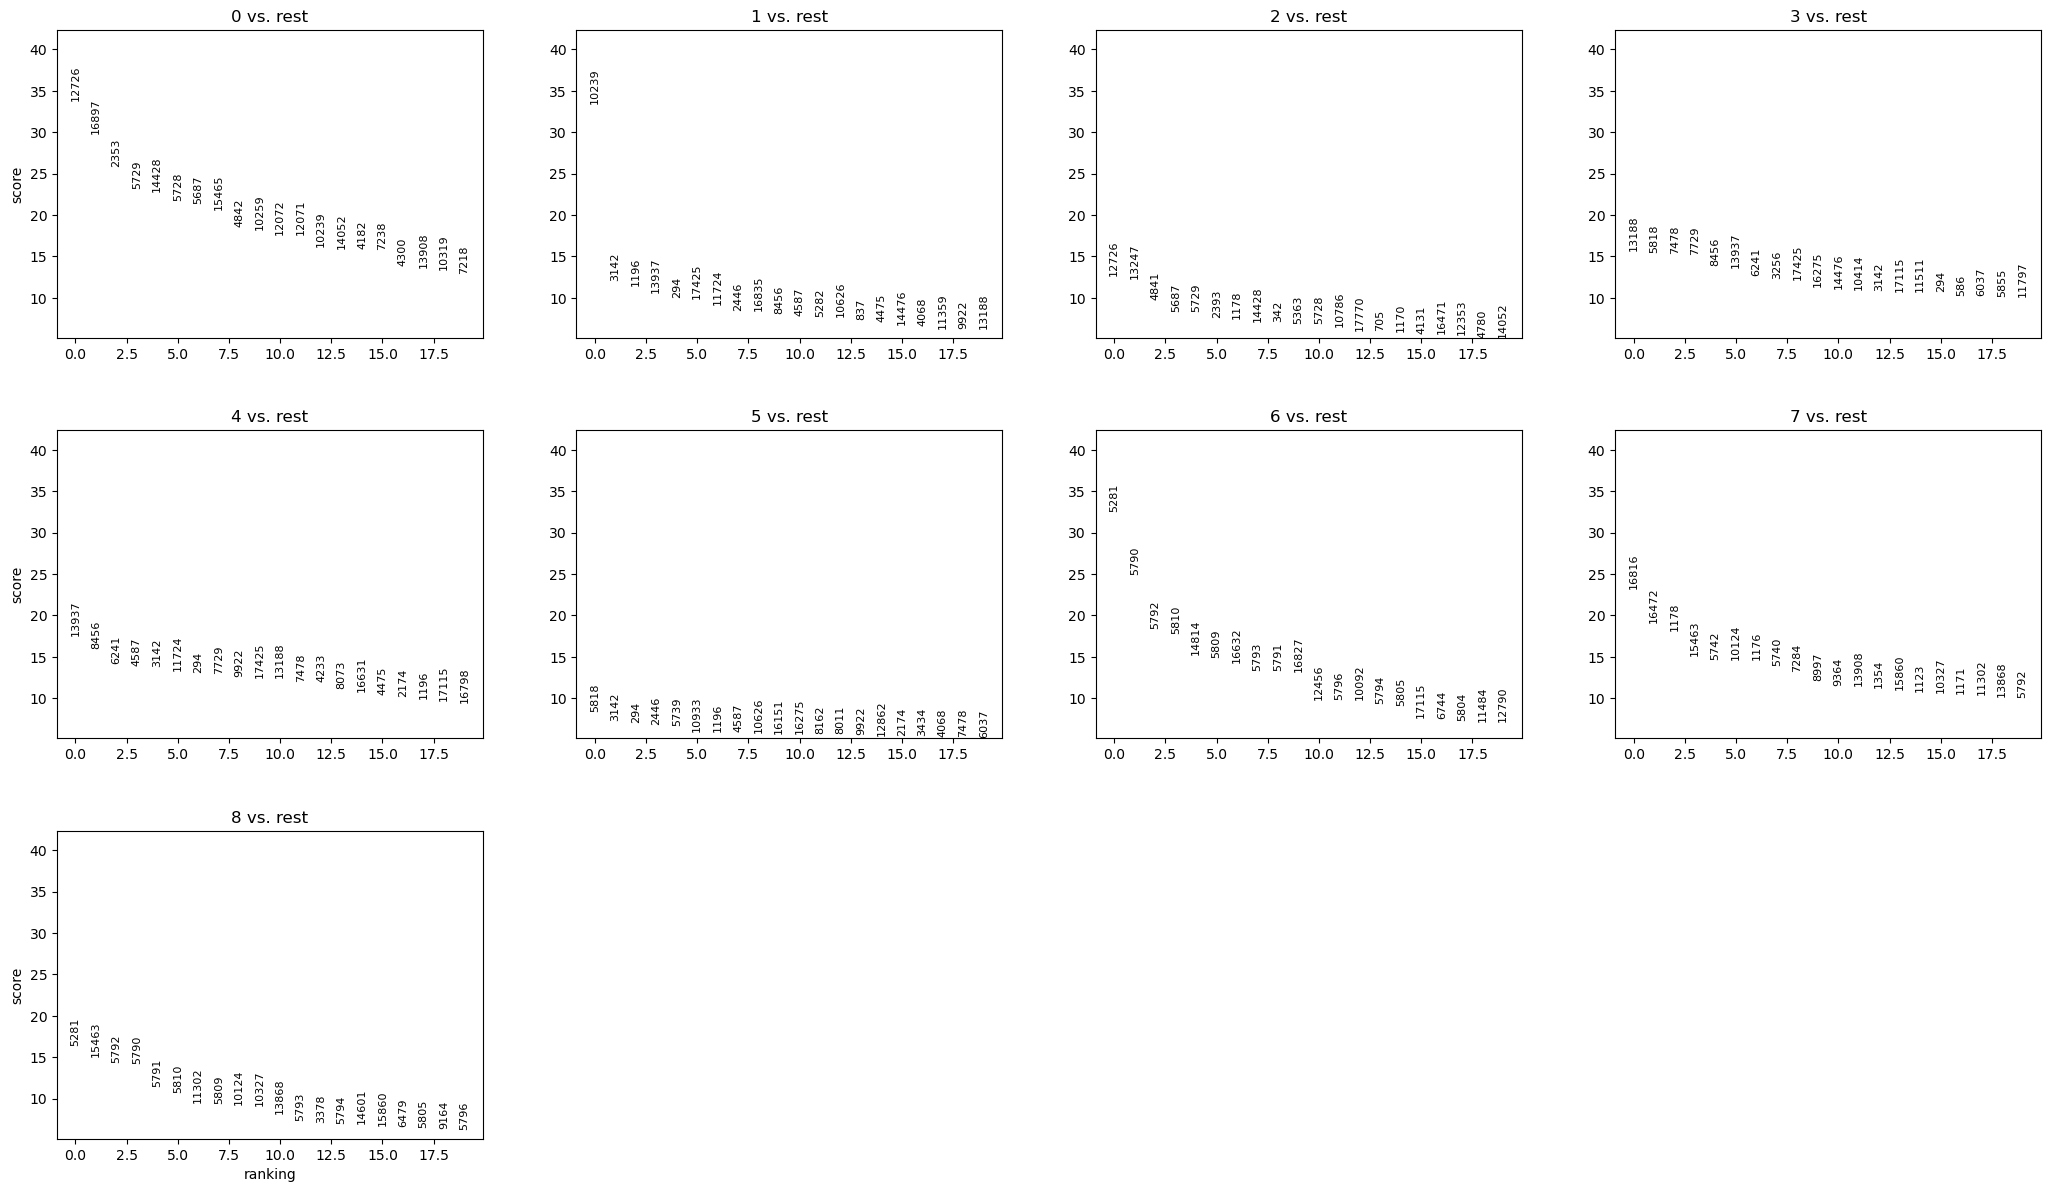

In [42]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata)

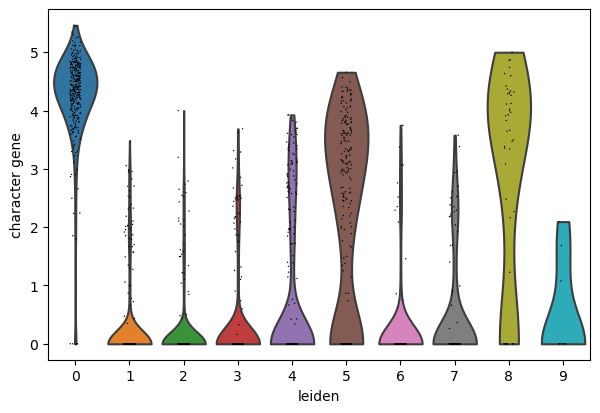

In [135]:
# cluster = adata[adata.obs['leiden']=='6']
# sc.pl.violin(cluster,keys=['16897'], groupby='cell_name', ylabel='character gene')

gen = adata[adata.obs['cell_name']=='gen_Cell']
sc.pl.violin(gen, keys=['16897'], groupby='leiden', ylabel='character gene')

# sc.pl.violin(cluster,keys='2353', groupby='cell_name', ylabel='gene 2353', split=True)
# sc.pl.stacked_violin(adata,var_names={'true_Cell':'5790','gen':'5790'}, groupby='leiden', figsize=(8,15))

<AxesSubplot:>

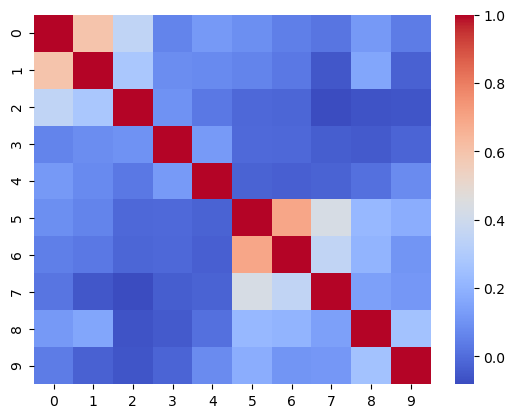

In [149]:
sim = adata[adata.obs['cell_name']=='gen_Cell']
real = adata[adata.obs['cell_name']=='true_Cell']
sim = sim[sim.obs['leiden']=='1']
real = real[real.obs['leiden']=='1']

markers = [16897,2353,15465,14428,12726]
mat = np.concatenate((sim.X[:300,markers],real.X[:300,markers]),axis=1)
# corr = np.zeros((5,5))
# for a, i in enumerate([16897,2353,15465,14428,12726]):
#     for b, j in enumerate([16897,2353,15465,14428,12726]):
#         corr[a,b] = np.corrcoef(sim.X[:321,i], real.X[:321,j])[0][1]
df = pd.DataFrame(mat)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm')

In [114]:
sim = adata[adata.obs['cell_name']=='gen_Cell']
real = adata[adata.obs['cell_name']=='true_Cell']
sim = sim[sim.obs['leiden']=='1']
real = real[real.obs['leiden']=='1']

In [98]:
df = pd.DataFrame(sim.X)
corr_matrix_gen = df.corr()
df = pd.DataFrame(real.X)
corr_matrix_real = df.corr()

Text(0.5, 1.0, 'gene correlation of generated cell')

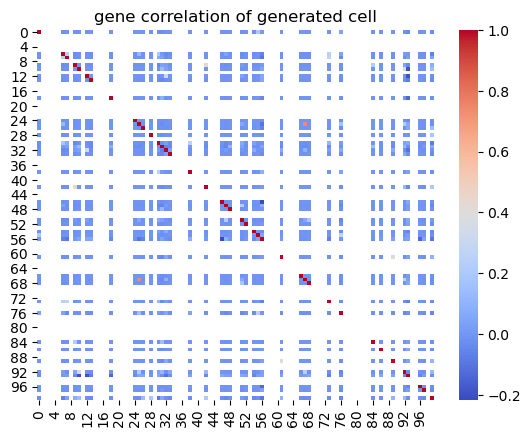

In [99]:
sns.heatmap(corr_matrix_gen.iloc[:100, :100], cmap='coolwarm')
# sns.heatmap(corr_matrix_gen, cmap='coolwarm')
plt.title('gene correlation of generated cell')

Text(0.5, 1.0, 'gene correlation of real cell')

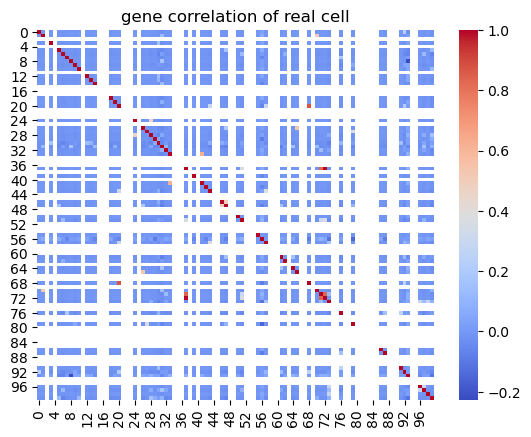

In [100]:
sns.heatmap(corr_matrix_real.iloc[:100, :100], cmap='coolwarm')
# sns.heatmap(corr_matrix_real, cmap='coolwarm')
plt.title('gene correlation of real cell')

存成csv给LISI用

In [15]:
# 再转回anndata便于scanpy处理
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=1500)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.filter_genes_dispersion(adata, n_top_genes=1500)
sc.tl.pca(adata, svd_solver='arpack')# svd_solver 指定奇异值分解 SVD 的方法
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

In [16]:
df = pd.DataFrame(adata.obsm['X_pca'][:,:2],columns=['PC1','PC2'])
df.to_csv('tmp_data/PCA.csv')

In [17]:
df = pd.DataFrame(adata.obsm['X_umap'],columns=['UMAP1','UMAP2'])
df.to_csv('tmp_data/UMAP.csv')

In [18]:
df = pd.DataFrame(adata.obs_names,columns=['category'])
df.to_csv('tmp_data/category.csv')

新的ood训练数据

In [5]:
test_adata1 = sc.read_h5ad('../scimilarity-main/data/TS_Blood.h5ad')
# test_adata1.obs['organ'] = ['Blood']*(test_adata1.X.toarray().shape[0])
# test_adata2.obs['free_annotation'].value_counts()

In [6]:
test_adata2 = sc.read_h5ad('../scimilarity-main/data/TS_Spleen.h5ad')
# test_adata2.obs['organ'] = ['Spleen']*(test_adata2.X.toarray().shape[0])
# test_adata2.obs['free_annotation'].value_counts()

In [7]:
test_adata3 = sc.read_h5ad('../scimilarity-main/data/TS_Bladder.h5ad')
# test_adata3.obs['organ'] = ['Bladder']*(test_adata3.X.toarray().shape[0])
# test_adata3.obs['free_annotation'].value_counts()[:20]

In [19]:
test_adata4 = sc.read_h5ad('../scimilarity-main/data/TS_Thymus.h5ad')
# test_adata4.obs['organ'] = ['Thymus']*(test_adata4.X.toarray().shape[0])

In [22]:
test_adata4.obs['free_annotation'].value_counts()[20:40]

vascular arterial endothelial cell                         355
cd8-positive, alpha-beta t cell                            349
monocyte                                                   346
Macrophages                                                303
lymphatic endothelial cell                                 256
endothelial cell of artery                                 181
medullary thymic epithelial cell                           166
macrophage                                                 158
nk cell                                                    105
mature nk t cell                                            89
plasma cell                                                 89
Monocytes                                                   88
fast muscle cell                                            86
Natural killer cells                                        80
immature natural killer cell                                44
Erythrocytes                                           

In [9]:
test_adata5 = sc.read_h5ad('../scimilarity-main/data/TS_Vasculature.h5ad')
# test_adata5.obs['organ'] = ['Vasculature']*(test_adata5.X.toarray().shape[0])
# test_adata5.obs['free_annotation'].value_counts()[:20]

In [28]:
test_adata4.obs.loc[test_adata4.obs['free_annotation'] == 'Plasma cells', 'free_annotation'] = 'plasma cell'

In [29]:
test_adata4[test_adata4.obs['free_annotation']=='plasma cell']

View of AnnData object with n_obs × n_vars = 1554 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [30]:
new_train = sc.concat([test_adata1,test_adata2,test_adata3,test_adata4,test_adata5])
new_train

AnnData object with n_obs × n_vars = 158403 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'

In [31]:
train_adata = new_train[np.where(np.in1d(new_train.obs['free_annotation'], ['memory b cell','plasma cell','nk cell','macrophage','fibroblast','naive b cell']))[0]]
train_adata

View of AnnData object with n_obs × n_vars = 50759 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'

In [32]:
train_adata.write('../data/sapiens/sapiens_ood_data.h5ad')

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [35]:
train_adata = sc.read_h5ad('../data/sapiens/sapiens_ood_data.h5ad')
print(train_adata)
cellclass = train_adata.obs['free_annotation']
organtype = train_adata.obs['organ_tissue']
celltype = [cellclass[i]+'_'+organtype[i] for i in range(len(cellclass))]
train_adata.obs['cellinfo'] = celltype

celltype_counts = train_adata.obs['cellinfo'].value_counts()  
  
# 找出数量少于500的细胞类型  
small_celltypes = celltype_counts[celltype_counts < 500].index  
  
# 过滤掉这些细胞类型  
adata_filtered = train_adata[~train_adata.obs['cellinfo'].isin(small_celltypes)].copy()
adata_filtered

AnnData object with n_obs × n_vars = 50759 × 28231
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    layers: 'decontXcounts', 'raw_counts'


AnnData object with n_obs × n_vars = 49357 × 28231
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'cellinfo'
    layers: 'decontXcounts', 'raw_counts'

In [36]:
adata_filtered.write('../data/sapiens/sapiens_ood_data.h5ad')

In [46]:
sc.pp.filter_genes(train_adata, min_cells=3)
sc.pp.filter_cells(train_adata, min_genes=10)
train_adata

AnnData object with n_obs × n_vars = 49294 × 43474
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'n_cells'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'

In [47]:
train_adata.obs['organ_tissue']

cell_id
AAACGAACACAAGCTT_TSP7_Blood_NA_10X_1_1                             Blood
AAACGAAGTGCAACGA_TSP7_Blood_NA_10X_1_1                             Blood
AAACGAATCTCGCAGG_TSP7_Blood_NA_10X_1_1                             Blood
AAACGCTCAAGGGCAT_TSP7_Blood_NA_10X_1_1                             Blood
AAAGAACGTCTCACGG_TSP7_Blood_NA_10X_1_1                             Blood
                                                                ...     
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P4_S364    Vasculature
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P5_S365    Vasculature
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P6_S366    Vasculature
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P7_S367    Vasculature
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P8_S368    Vasculature
Name: organ_tissue, Length: 49294, dtype: category
Categories (5, object): ['Bladder', 'Blood', 'Spleen', 'Thymus', 'Vasculature']

In [48]:
train_adata.obs['free_annotation']

cell_id
AAACGAACACAAGCTT_TSP7_Blood_NA_10X_1_1                        naive b cell
AAACGAAGTGCAACGA_TSP7_Blood_NA_10X_1_1                             nk cell
AAACGAATCTCGCAGG_TSP7_Blood_NA_10X_1_1                             nk cell
AAACGCTCAAGGGCAT_TSP7_Blood_NA_10X_1_1                       memory b cell
AAAGAACGTCTCACGG_TSP7_Blood_NA_10X_1_1                             nk cell
                                                                 ...      
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P4_S364       macrophage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P5_S365       macrophage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P6_S366       macrophage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P7_S367       macrophage
TSP2_Vasculature_aorta_SS2_B113343_B133091_Immune_P8_S368       macrophage
Name: free_annotation, Length: 49294, dtype: category
Categories (6, object): ['fibroblast', 'macrophage', 'memory b cell', 'naive b cell', 'nk cell', 'plasma cell']